# A2 GuadModel:  02 VariableAnnuity

---
## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

---
## 1. Assumptions

In [2]:
mortality_tables = pd.read_csv('StdMort.csv')
mortality_tables.fillna(1.0, inplace=True)  # 欠損部分（高齢）は1で埋める．
mortality_tables.head(10)

,Age,Term_M,Term_F,Morb_M,Morb_F,Annuity_M,Annuity_F
0,0,0.00081,0.00078,0.00053,0.00052,0.00058,0.00047
1,1,0.00056,0.00053,0.00022,0.00020,0.00026,0.00022
2,2,0.00036,0.00033,0.00015,0.00014,0.00020,0.00015
3,3,0.00022,0.00019,0.00011,0.00009,0.00014,0.00010
4,4,0.00014,0.00011,0.00008,0.00007,0.00011,0.00007
5,5,0.00010,0.00008,0.00006,0.00006,0.00009,0.00006
6,6,0.00009,0.00008,0.00006,0.00005,0.00009,0.00006
7,7,0.00009,0.00008,0.00006,0.00005,0.00007,0.00005
8,8,0.00009,0.00007,0.00005,0.00004,0.00006,0.00004
9,9,0.00009,0.00007,0.00005,0.00004,0.00006,0.00004


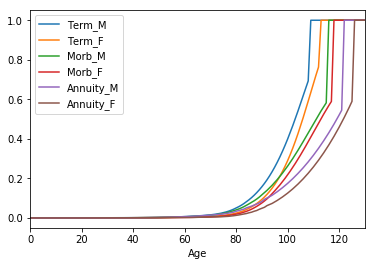

In [3]:
mortality_tables.plot(x='Age')

In [4]:
# Mortality
# 面倒なので，死亡保険用をV基礎（最も保守的）・医療保険料をP基礎・年金開始後用をbest estimateとして使用する．
pricing_mortality = torch.tensor(mortality_tables['Morb_M'], requires_grad=True)
reserve_mortality = torch.tensor(mortality_tables['Morb_M'], requires_grad=True)
valuation_mortality = torch.tensor(mortality_tables['Morb_M'], requires_grad=True)

---
## 2. Modeling

In [7]:
def gen_reserve(n_samples, term, 
                current_unit_price, 
                i, mu, sigma, cog,
                mortality,
                dynamic_lapse):
    
    # generate stochastic scenarios
    sample = torch.tensor(np.random.randn(n_samples, term), dtype=torch.float32)
    growth_rate = mu + sigma * sample

    # define unit price
    unit_price = torch.cat([torch.ones(n_samples, 1), torch.cumprod((1 + growth_rate - cog), dim=1)], dim=1)
    unit_price = unit_price[:, :term] * current_unit_price

    # define face
    premium = cog * unit_price
    benefit_death = torch.max(torch.zeros(1), 1 - unit_price)  # GMDB
    benefit_lapse = torch.max(torch.zeros(1), unit_price - unit_price)  # not GMWB

    # calc decrement
    mortality = torch.reshape(mortality, (1, -1))[:, :term]
    lapse = dynamic_lapse(unit_price)

    lxt1 = torch.cumprod((1 - mortality) * (1 - lapse), dim=1)
    lxt = torch.cat([torch.ones(lxt1.shape[0], 1), lxt1[:, :-1]], dim=1)
    d_death = lxt * mortality * (1 - lapse/2)
    d_lapse = lxt * lapse * (1 - mortality/2)

    # define model fog guarantee reserve
    # discount rate
    v = 1 / (1 + i)
    vt = torch.pow(v, torch.arange(lxt.shape[0], dtype=torch.float32)).reshape(1, -1)[:, :term]

    # calculate CF
    CF_premium = premium * lxt
    CF_benefit_death = benefit_death * d_death
    CF_benefit_lapse = benefit_lapse * d_lapse
    CF_total = CF_premium - CF_benefit_death - CF_benefit_lapse

    PV_premium = torch.mean(torch.sum(vt * CF_premium, dim=1))
    PV_benefit_death = torch.mean(torch.sum(vt * CF_benefit_death, dim=1))
    PV_benefit_lapse = torch.mean(torch.sum(vt * CF_benefit_lapse, dim=1))
    PV_total = torch.mean(torch.sum(vt * CF_total, dim=1))

    Reserve = -PV_total
    
    return Reserve, PV_premium, PV_benefit_death, PV_benefit_lapse



In [8]:
kwargs = {}
kwargs['n_samples'] = 10000
kwargs['term'] = 10

# condition
kwargs['current_unit_price'] = 0.8

# market relateds
kwargs['i'] = torch.tensor(np.array(1.5/100), requires_grad=True, dtype=torch.float32)
kwargs['mu'] = torch.tensor(np.array(-1.5/100), requires_grad=True, dtype=torch.float32)  # MER = 3%
kwargs['sigma'] = torch.tensor(np.array(20.0/100), requires_grad=True, dtype=torch.float32)

# net premium for guarantee
kwargs['cog'] = torch.tensor(np.array(0.5/100), requires_grad=True, dtype=torch.float32)

# Mortality
kwargs['mortality'] = reserve_mortality[60:60+10]

# Lapse
# dynamic lapse assumption
lapse_min = torch.tensor(np.array(0.0), requires_grad=True, dtype=torch.float32)
lapse_max = torch.tensor(np.array(0.3), requires_grad=True, dtype=torch.float32)
position_min = torch.tensor(np.array(0.8), requires_grad=True, dtype=torch.float32)
position_max = torch.tensor(np.array(1.4), requires_grad=True, dtype=torch.float32)

kwargs['dynamic_lapse'] = lambda x: lapse_min + (lapse_max - lapse_min) * \
                            torch.sigmoid(5 * (x - position_min) / (position_max - position_min))  # x is unit price

# grad collection
grad_node_list = [kwargs['i'], kwargs['mu'], kwargs['sigma'],
                  kwargs['cog'], kwargs['mortality'],
                  lapse_min, lapse_max, position_min, position_max]

In [9]:
# clear grad
grad_dic = {'unit_price':[], 'cog':[], 'i':[], 'mu':[], 'sigma':[], 
                'lapse_min':[], 'lapse_max':[], 'lapse_pos_min':[], 'lapse_pos_max':[]}
value_dic = {'unit_price':[], 'reserve':[], 'premium':[], 'benefit_death':[], 'benefit_lapse':[]}

for uc in np.linspace(0, 1.5, 151):
    kwargs['current_unit_price'] = uc
    for node in grad_node_list:
        try:
            node.grad.data.zero_()
        except:
            pass

    # forward and backward
    Reserve, PV_premium, PV_benefit_death, PV_benefit_lapse = gen_reserve(**kwargs)
    Reserve.backward()

    # collection
    grad_dic['unit_price'].append(uc)
    
    grad_dic['cog'].append(np.array(kwargs['cog'].grad.data))

    grad_dic['i'].append(np.array(kwargs['i'].grad.data))

    grad_dic['mu'].append(np.array(kwargs['mu'].grad.data))
    grad_dic['sigma'].append(np.array(kwargs['sigma'].grad.data))

    grad_dic['lapse_min'].append(np.array(lapse_min.grad.data))
    grad_dic['lapse_max'].append(np.array(lapse_max.grad.data))
    grad_dic['lapse_pos_min'].append(np.array(position_min.grad.data))
    grad_dic['lapse_pos_max'].append(np.array(position_max.grad.data))
    
    # value collection
    value_dic['unit_price'].append(uc)
    value_dic['reserve'].append(np.array(Reserve.data))
    value_dic['premium'].append(np.array(PV_premium.data))
    value_dic['benefit_death'].append(np.array(PV_benefit_death.data))
    value_dic['benefit_lapse'].append(np.array(PV_benefit_lapse.data))

value_dic = {key: np.array(value_dic[key]) for key in value_dic.keys()}
grad_dic = {key: np.array(grad_dic[key]) for key in grad_dic.keys()}

---
## 3. Results

In [10]:
df = pd.DataFrame.from_dict(grad_dic)

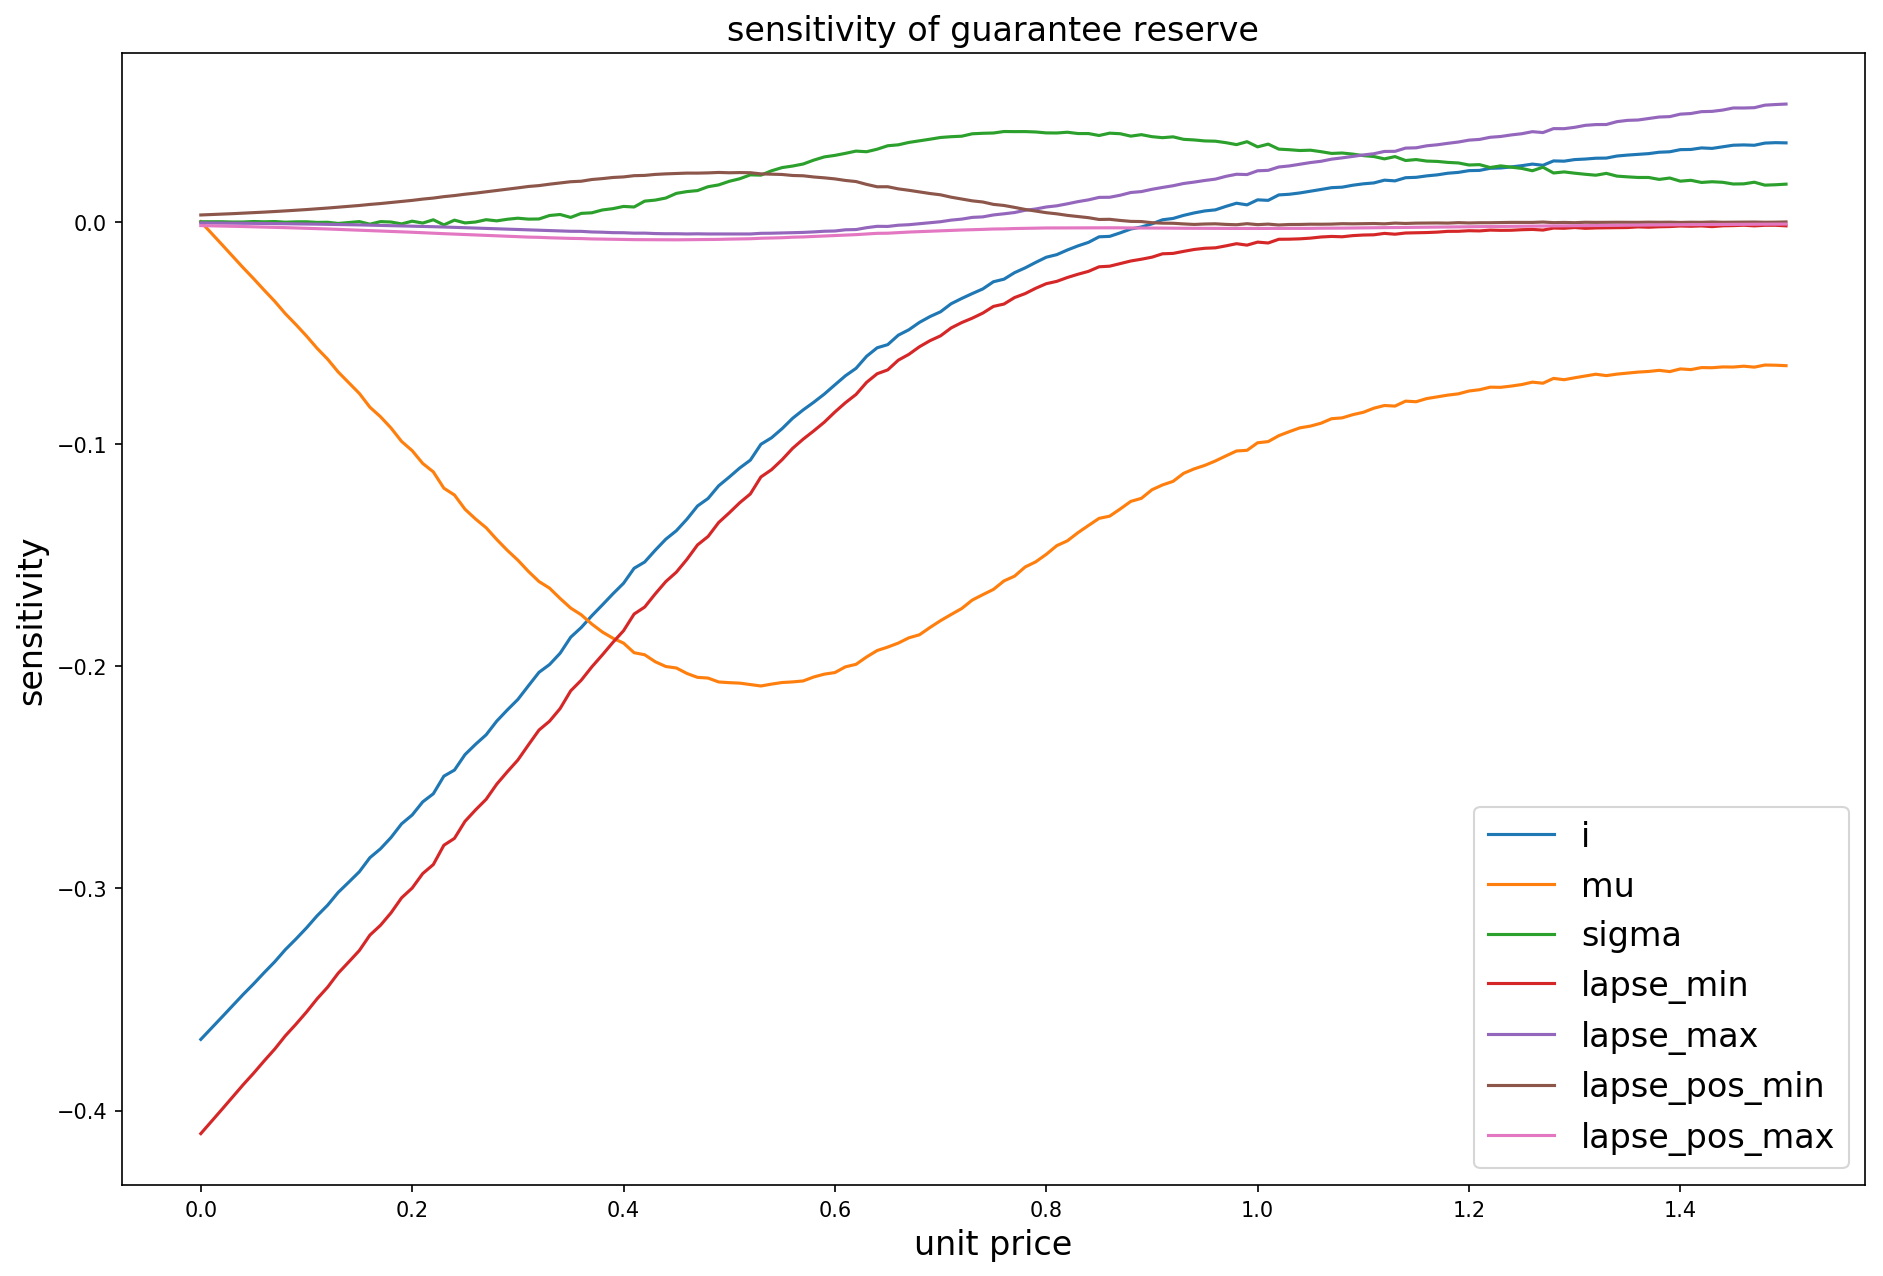

In [13]:
plt.figure(figsize=(15, 10), dpi=150)
for key in grad_dic.keys():
    if key != 'unit_price' and key != 'cog':
        plt.plot(df['unit_price'], df[key], label=key)

plt.title('sensitivity of guarantee reserve', size=16)
plt.ylabel('sensitivity', size=16)
plt.xlabel('unit price', size=16)
plt.legend(fontsize=16)
plt.show()

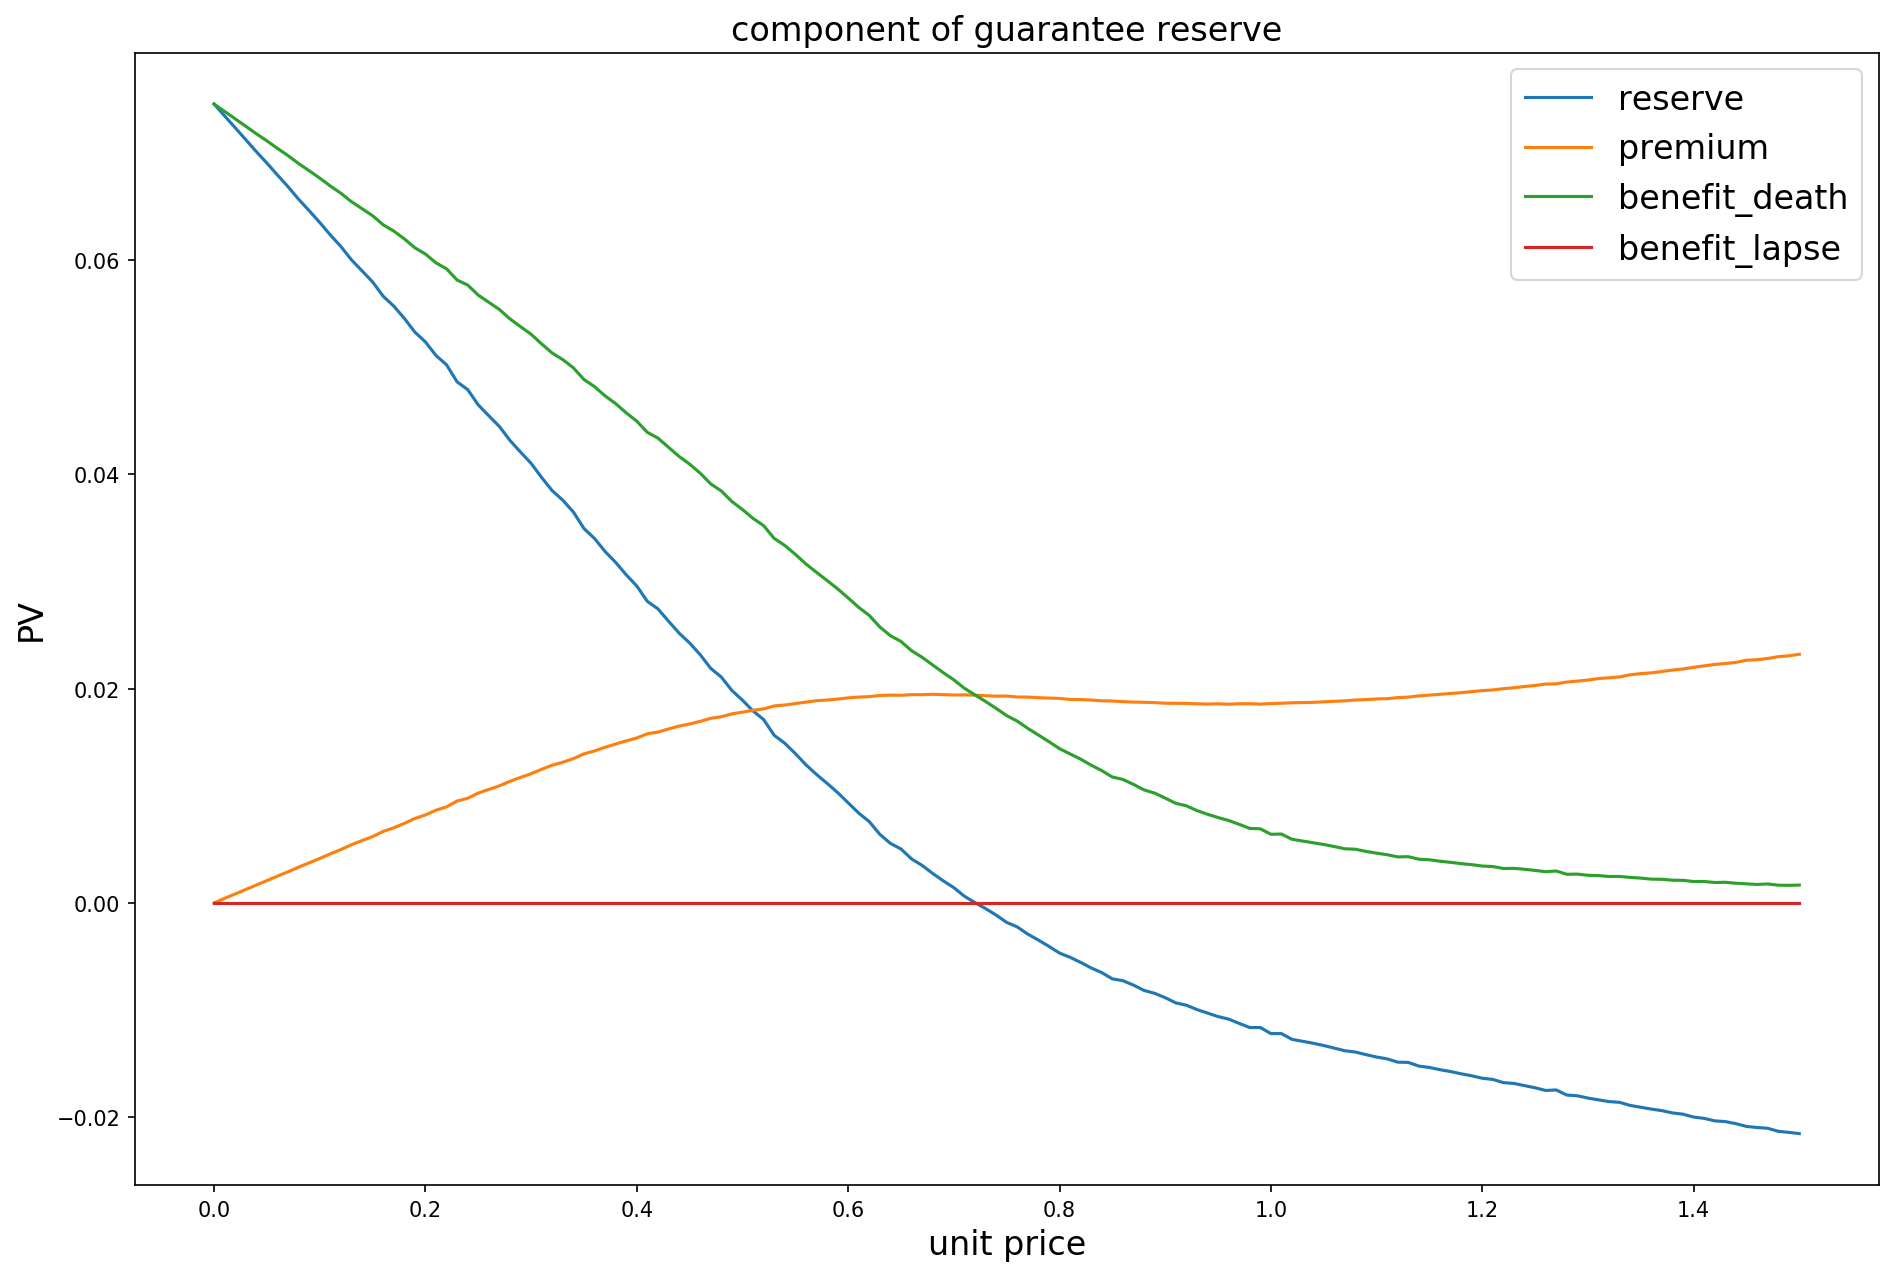

In [14]:
df_value = pd.DataFrame.from_dict(value_dic)
plt.figure(figsize=(15, 10), dpi=150)
for key in value_dic.keys():
    if key != 'unit_price':
        plt.plot(df_value['unit_price'], df_value[key], label=key)

plt.title('component of guarantee reserve', size=16)
plt.ylabel('PV', size=16)
plt.xlabel('unit price', size=16)
plt.legend(fontsize=16)
plt.show()